## F値上げ作戦

#### 概要
- cepstrumsにある001,005,010,011,013の５つのデータを使用
- １つは評価用データとして他はtraindataとする。
- 評価用データを使ってF値を出す。
- ブーストする。
- 繰り返し、評価値を上げる。

#### 方針
- 学習にはLSTM,SVM等を使う。
- データを4:1に分けたあと4つ~~のtraindataを3:1に分ける~~
- ~~ブースト方法はxgboost,lightGBM~~
- active learning
 - ~~最初に3でtrainをし1のデータでtest~~
 - 4つでtrain
 - 評価用の１日のデータでtest
 - testの出力結果からあいまいな結果のデータをリスト化
 - traindataに前述のリストを追加
 - 再学習
 - 曖昧な結果が一通りなくなったら評価用データの別日のデータでtest
- activelearningの有効性を示す。

In [1]:
import os
from os import path
from argparse import ArgumentParser

import glob
import numpy as np
from numpy.lib.stride_tricks import as_strided
import pandas as pd

import tensorflow as tf
from keras import backend as K
from keras.utils import np_utils

import create_model
from create_model import read_csv,read_datas,test2main
import pandas as pd

Using TensorFlow backend.
/home/aj1m0n/jupyter_notebook/Datamining/20180731/create_model.py:176: SyntaxWarning: name 'predicted' is assigned to before global declaration
  global predicted #モジュールのグローバル化


#### 組み合わせ

In [2]:
import itertools
directory_list = ["001", "005", "010", "011", "013"]
combi_list = list(itertools.combinations(directory_list,4))

In [3]:
for combi in combi_list:
    print(combi)
    test_data = [i for i in directory_list if not i in combi]
    print(test_data)
    test2main("/home/aj1m0n/jupyter_notebook/Datamining/20180731/cepstrums/",
              "./models/201808017/model/model%s_%s_%s_%s.json" %combi,
              "./models/201808017/eval/eval%s_%s_%s_%s.csv" %combi,
              "./models/201808017/weight/weight%s_%s_%s_%s.h5" %combi,
              "./models/201808017/predict/",
              100,
              40,
              180,
              3,
              1,
              list(combi),
              test_data
              )
    

('001', '005', '010', '011')
['013']


/home/aj1m0n/jupyter_notebook/Datamining/20180731/create_model.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _labels["date"] = np.datetime_as_string(labels.timestamp, "D")#timeごとに整列化


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 180)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 180)               259920    
_________________________________________________________________
Dense1 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense2 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense3 (Dense)               (None, 4)                 724       
_________________________________________________________________
out (Dense)                  (None, 4)                 20        
Total params: 325,824
Trainable params: 325,824
Non-trainable params: 0
_________________________________________________________________
Trai

### predicted dataの処理

In [4]:
labelcsv = pd.read_csv("./cepstrums/013/013_20170512_000.label.csv")

In [2]:
create_model._label

AttributeError: module 'create_model' has no attribute '_label'

In [5]:
labelcsv["timestamp"]

0        2017-05-12T08:18:19.364
1        2017-05-12T08:18:20.364
2        2017-05-12T08:18:21.364
3        2017-05-12T08:18:22.364
4        2017-05-12T08:18:23.364
5        2017-05-12T08:18:24.363
6        2017-05-12T08:18:25.364
7        2017-05-12T08:18:26.364
8        2017-05-12T08:18:27.364
9        2017-05-12T08:18:28.364
10       2017-05-12T08:18:29.364
11       2017-05-12T08:18:30.364
12       2017-05-12T08:18:31.364
13       2017-05-12T08:18:32.364
14       2017-05-12T08:18:33.364
15       2017-05-12T08:18:34.364
16       2017-05-12T08:18:35.364
17       2017-05-12T08:18:36.364
18       2017-05-12T08:18:37.364
19       2017-05-12T08:18:38.364
20       2017-05-12T08:18:39.363
21       2017-05-12T08:18:40.363
22       2017-05-12T08:18:41.363
23       2017-05-12T08:18:42.363
24       2017-05-12T08:18:43.363
25       2017-05-12T08:18:44.363
26       2017-05-12T08:18:45.363
27       2017-05-12T08:18:46.363
28       2017-05-12T08:18:47.363
29       2017-05-12T08:18:48.363
          

In [6]:
pd.DataFrame(create_model.predicted).to_csv("./models/20180802/predicted013.csv",header=("NO_LABEL", "ROLL", "RUN", "DOOR"), index=False)

In [2]:
predicted013 = pd.read_csv("./models/20180802/predicted013.csv")
predicted013.head()

,NO_LABEL,ROLL,RUN,DOOR
0,0.167289,0.000181,0.832329,0.000201
1,0.261441,0.000992,0.737331,0.000236
2,0.337246,0.001861,0.660809,0.000085
3,0.381247,0.004716,0.613814,0.000223
4,0.362594,0.003354,0.633884,0.000168


In [5]:
predicted013["timestamp"] = labelcsv["timestamp"]

In [6]:
predicted013 = predicted013.set_index("timestamp")

In [5]:
predicted013.max

<bound method DataFrame.max of        NO_LABEL      ROLL       RUN          DOOR                timestamp
0      0.167289  0.000181  0.832329  2.011868e-04  2017-05-12T08:18:19.364
1      0.261441  0.000992  0.737331  2.357286e-04  2017-05-12T08:18:20.364
2      0.337246  0.001861  0.660809  8.459464e-05  2017-05-12T08:18:21.364
3      0.381247  0.004716  0.613814  2.231172e-04  2017-05-12T08:18:22.364
4      0.362594  0.003354  0.633884  1.679605e-04  2017-05-12T08:18:23.364
5      0.388502  0.003409  0.608009  7.991047e-05  2017-05-12T08:18:24.363
6      0.396020  0.006538  0.597119  3.229514e-04  2017-05-12T08:18:25.364
7      0.385846  0.005252  0.608648  2.540962e-04  2017-05-12T08:18:26.364
8      0.352676  0.002025  0.645235  6.428149e-05  2017-05-12T08:18:27.364
9      0.387179  0.005459  0.607093  2.687322e-04  2017-05-12T08:18:28.364
10     0.351297  0.005092  0.642937  6.743468e-04  2017-05-12T08:18:29.364
11     0.296068  0.001271  0.702535  1.266870e-04  2017-05-12T08:18:3

In [17]:
timelist = []
for index, row in predicted013.iterrows():
    if row.max() < 0.5:
        timelist.append(index)

In [3]:
test = pd.read_csv("./models/20180806/predict/predicted-013013_20170407_000.csv")
test.head()

,NO_LABEL,ROLL,RUN,DOOR
0,0.212231,0.000395,0.785748,0.001626
1,0.233211,0.001141,0.764171,0.001477
2,0.235122,0.001388,0.762440,0.001049
3,0.233136,0.001322,0.764637,0.000905
4,0.232868,0.001290,0.764902,0.000940


## 曖昧データ処理

### timestamp抽出csv変換

In [2]:
import MSclass
import glob

In [ ]:
osmkdir("./models/20180806/")

In [6]:
for A in [0.5,0.6,0.7,0.8,0.9,1]:
    MSclass.predata("./models/20180806/predict/",
                   A,
                   "./models/20180806/class/"
                  )
    

### readcsv for time

In [4]:
import create_model
create_model.read_csv()

TypeError: read_csv() missing 5 required positional arguments: 'accel_file', 'gyro_file', 'label_file', 'timestep', and 'timeshift'

### 再学習

In [ ]:
    import itertools
    directory_list = ["001", "005", "010", "011", "013"]
    combi_list = list(itertools.combinations(directory_list,4))
    outeval = "./models/20180807/act_eval/eval%s_%s_%s_%s.csv" %combi

In [2]:
import pandas as pd
classcsv = pd.read_csv("./models/20180806/class/0.1-001001_20170406_000.csv")
accel = pd.read_csv("./cepstrums/001/001_20170406_000.accel.csv")
gyro = pd.read_csv("./cepstrums/001/001_20170406_000.gyro.csv")
label = pd.read_csv("./cepstrums/001/001_20170406_000.label.csv")

accel[accel["timestamp"] == classcsv["timestamp"]]

ValueError: Series lengths must match to compare

In [2]:
import numpy as np
from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils
from keras.optimizers import Adam
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
import os.path

import create_model

#pra
batch_size = 100
epochs = 40
units = 180
timestep = 3
timeshift = 1

#ファイルの読み込み

_edata, _elabel = create_model.read_csv()#曖昧データの読み込み
_elabel = np_utils.to_categorical(np.argmax(_elabel[["NO_LABEL", "ROLL", "RUN", "DOOR"]].values, axis = -1), num_classes = 4)

[]
f_model = './models/20180806/model/'
model_filename = []
f_weithts = "./models/20180806/weight/"
weights_filename = []

#曖昧dataの読み込み

#random seed を固定
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(1)
session_conf = tf.ConfigProto(
intra_op_parallelism_threads=1,
inter_op_parallelism_threads=1
)
tf.set_random_seed(1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
KTF.set_session(sess)#固定終わり

with open(outeval, "wt") as f:

    json_string = open(os.path.join(f_model, model_filename)).read()
    model = model_from_json(json_string)    
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.5), metrics=['accuracy'])
    model.load_weights(os.path.join(f_model,weights_filename))

    cbks = []

    history = model.fit(xdata, xlabel, batch_size = 100, epochs = epochs, callbacks = []
                  , validation_data = [ydata, ylabel], class_weight = _class_weight
                  , verbose = 2)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    #F値の処理
    try:
        _tlabel = np.argmax(_elabel, axis = -1)
        _plabel = np.argmax(predicted, axis = -1)
        for _t, _p in zip(_tlabel, _plabel):
            if _t == _p: counts[_p, 0] += 1
            counts[_p, 1] += 1
            counts[_t, 2] += 1
        _macro_fmesure = 0.0
        _fmesures = []
        for _i in range(4):
            if counts[_i, 1] == 0 or counts[_i, 2] == 0: continue
            _precision = counts[_i, 0] / counts[_i, 1]
            _recall = counts[_i, 0] / counts[_i, 2]
            _fmesure = 2 * (_precision * _recall) / (_precision + _recall)
            _macro_fmesure += _fmesure
            _fmesures.append(_fmesure)
        _macro_fmesure /= 4

        line = [path.basename(_accel), path.basename(_gyro), path.basename(_label), str(_edata.shape[0])
                , "{:0.8f}".format(eval[0]), "{:0.8f}".format(eval[1]), "{:0.8f}".format(_macro_fmesure)]
        line += ["{:0.8f}".format(v) for v in _fmesures]
        f.write(",".join(line))
        f.write("\n")
    except:
        print("ERROR", _edata, predicted)
        _macro_fmesure = 0.0
        line = [path.basename(_accel), path.basename(_gyro), path.basename(_label), str(_edata.shape[0])
                , "{:0.8f}".format(eval[0]), "{:0.8f}".format(eval[1]), "{:0.8f}".format(_macro_fmesure)]
        f.write(",".join(line))
        f.write("\n")
finally:
    session.close()
    print('Goodbye, world!')

SyntaxError: invalid syntax (<ipython-input-2-9d7b43be367b>, line 93)

In [3]:
import MSclass

In [5]:

MSclass.create_vaguedata("./models/20180806/class/",
                        ["011"],
                         "./models/20180809/vague/",
                         0.1
                        )

In [3]:
from relearning import relearning

relearning(f_cep = "./models/20180809/vague/0.1/",
    f_model = "./models/20180806/model/",
    f_weight = "./models/20180806/weight/",
    car_ids =  ["001","005","010","011","013"],
    eval_car_ids = ["001","005","010","011","013"],
    outeval = "./models/20180809/eval/reeval/",
    outmodel = "./models/20180809/model/",
    outweights = "./models/20180809/weight/",
    outpredict = "./models/20180809/predict/",
    batch_size = 100,
    epochs = 40,
    units = 180,
    timestep = 3,
    timeshift = 1,
)

/home/aj1m0n/jupyter_notebook/Datamining/20180731/relearning.py:111: SyntaxWarning: name 'predicted' is assigned to before global declaration
  global predicted #モジュールのグローバル化
Using TensorFlow backend.


['./models/20180809/vague/0.1/001/*.label.csv']
./models/20180806/model/model005_010_011_013.model


/home/aj1m0n/jupyter_notebook/Datamining/20180731/create_model.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _labels["date"] = np.datetime_as_string(labels.timestamp, "D")#timeごとに整列化


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 180)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 180)               259920    
_________________________________________________________________
Dense1 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense2 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense3 (Dense)               (None, 4)                 724       
_________________________________________________________________
out (Dense)                  (None, 4)                 20        
Total params: 325,824
Trainable params: 325,824
Non-trainable params: 0
_________________________________________________________________
Trai

TypeError: 'NoneType' object is not subscriptable

In [1]:
from relearning import relearning

relearning(f_cep = "./models/20180809/vague/0.1/",
    f_model = "./models/20180806/model/",
    f_weight = "./models/20180806/weight/",
    car_ids =  ["001","005","010","011","013"],
    eval_car_ids = ["001","005","010","011","013"],
    outeval = "./models/20180809/eval/reeval/",
    outmodel = "./models/20180809/model/",
    outweights = "./models/20180809/weight/",
    outpredict = "./models/20180809/predict/",
    batch_size = 100,
    epochs = 40,
    units = 180,
    timestep = 3,
    timeshift = 1,
)

Using TensorFlow backend.


./models/20180809/vague/0.1/001/001_20170407_000.vague.label.csv
001_20170407_000
['./models/20180809/vague/0.1/001/001_20170407_000.vague.label.csv']
./models/20180806/model/model005_010_011_013.model


/home/aj1m0n/jupyter_notebook/Datamining/20180731/create_model.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _labels["date"] = np.datetime_as_string(labels.timestamp, "D")#timeごとに整列化


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 180)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 180)               259920    
_________________________________________________________________
Dense1 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense2 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense3 (Dense)               (None, 4)                 724       
_________________________________________________________________
out (Dense)                  (None, 4)                 20        
Total params: 325,824
Trainable params: 325,824
Non-trainable params: 0
_________________________________________________________________
Trai

KeyboardInterrupt: 

In [3]:
from relearning import relearning

relearning(f_cep = "./models/20180809/vague/0.1/",
    f_model = "./models/20180806/model/",
    f_weight = "./models/20180806/weight/",
    car_ids =  ["001","005","010","011","013"],
    eval_car_ids = ["001","005","010","011","013"],
    outeval = "./models/20180813/eval/reeval/",
    outmodel = "./models/20180813/model/",
    outweights = "./models/20180813/weight/",
    outpredict = "./models/20180813/predict/",
    batch_size = 100,
    epochs = 40,
    units = 180,
    timestep = 3,
    timeshift = 1,
)

./models/20180809/vague/0.1/001/001_20170407_000.vague.label.csv
001_20170407_000
['./models/20180809/vague/0.1/001/001_20170407_000.vague.label.csv']
./models/20180806/model/model005_010_011_013.model


/home/aj1m0n/jupyter_notebook/Datamining/20180731/create_model.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _labels["date"] = np.datetime_as_string(labels.timestamp, "D")#timeごとに整列化


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 180)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 180)               259920    
_________________________________________________________________
Dense1 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense2 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense3 (Dense)               (None, 4)                 724       
_________________________________________________________________
out (Dense)                  (None, 4)                 20        
Total params: 325,824
Trainable params: 325,824
Non-trainable params: 0
_________________________________________________________________
Trai

## 3rdlearning

このレイヤーで段階的学習を行う<br>
ex.
1. 車ABCDで学習を行ったモデルを車Aに適応
2. 1日の確率で表せれた予測値からmargin sampleing(max - 2nd max)を行う
3. その差が0.1以下のデータとそれに対応したラベルデータを入力としてモデルを再学習
4. そのモデルで車Eの別日を予測
5. 2に戻る

### create vague data

### 3nd学習

ex.
1. 20170406のサンプリングデータで再学習させたモデルを適用
2. データは 20170406 20170407 2017040511 20170412 (ただし20170406は既にモデルに組まれているので無視をする)
3. 20170407以降のデータを参照前回のreevalからaccracyが上がっているかを確認する
4. 20170407のモデルを適用、20170511以降のデータを見る

In [2]:
import MSclass
for A in [0.1]:
    MSclass.predata("./models/20180813/predict/010_20170406_000/",
                   A,
                   "./models/20180813/class/"
                  )
MSclass.create_vaguedata("./models/20180813/class/",
                        ["013"],
                         "./models/20180813/vague/",
                         0.1
                        )

In [14]:
from relearning import relearning

relearning(f_cep = "./models/20180813/vague/0.1/",
    f_model = "./models/20180810/model/010_20170406_000/",
    f_weight = "./models/20180810/weight/010_20170406_000/",
    car_ids =   ["010"],
    eval_car_ids =  ["001","005","010","011","013"],
    outeval = "./models/20180813/eval/3rdeval/",
    outmodel = "./models/20180813/model/3rdmodel/",
    outweights = "./models/20180813/weight/3rdweight/",
    outpredict = "./models/20180813/predict/3rdpredict/",
    batch_size = 100,
    epochs = 23,
    units = 180,
    timestep = 3,
    timeshift = 1,
)

[['./models/20180810/model/010_20170406_000/re-model001_005_011_013.model']]
['./models/20180813/vague/0.1/010/010_20170512_000.vague.label.csv', './models/20180813/vague/0.1/010/010_20170511_000.vague.label.csv', './models/20180813/vague/0.1/010/010_20170406_000.vague.label.csv', './models/20180813/vague/0.1/010/010_20170407_000.vague.label.csv']
./models/20180813/vague/0.1/010/010_20170512_000.vague.label.csv
010_20170512_000
['./models/20180813/vague/0.1/010/010_20170512_000.vague.label.csv']


/home/aj1m0n/jupyter_notebook/Datamining/20180731/create_model.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _labels["date"] = np.datetime_as_string(labels.timestamp, "D")#timeごとに整列化


./models/20180810/model/010_20170406_000/re-model001_005_011_013.model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 180)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 180)               259920    
_________________________________________________________________
Dense1 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense2 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense3 (Dense)               (None, 4)                 724       
_________________________________________________________________
out (Dense)                  (None, 4)                 20        
Total params: 325,824
Trainable params: 325,824
Non-trainable params: 0

### accracy Comparison

In [ ]:
#plot

### 4th学習

In [9]:
import MSclass
for A in [0.1]:
    MSclass.predata("./models/20180813/predict/010_20170407_000/",
                   A,
                   "./models/20180813/class/4th/"
                  )
MSclass.create_vaguedata("./models/20180813/class/4th/",
                        ["010","013"],
                         "./models/20180813/vague/4th/",
                         0.1
                        )

In [11]:
from relearning import relearning

relearning(f_cep = "./models/20180813/vague/0.1/",
    f_model = "./models/20180810/model/013_20170407_000/",
    f_weight = "./models/20180810/weight/013_20170407_000/",
    car_ids =  ["010"],
    eval_car_ids = ["010"],
    outeval = "./models/20180813/eval/4theval/",
    outmodel = "./models/20180813/model/4thmodel/",
    outweights = "./models/20180813/weight/4thweight/",
    outpredict = "./models/20180813/predict/4thpredict/",
    batch_size = 100,
    epochs = 40,
    units = 180,
    timestep = 3,
    timeshift = 1,
)

[['./models/20180810/model/013_20170407_000/re-model001_005_010_011.model']]
['./models/20180813/vague/0.1/010/010_20170512_000.vague.label.csv', './models/20180813/vague/0.1/010/010_20170511_000.vague.label.csv', './models/20180813/vague/0.1/010/010_20170406_000.vague.label.csv', './models/20180813/vague/0.1/010/010_20170407_000.vague.label.csv']
./models/20180813/vague/0.1/010/010_20170512_000.vague.label.csv
010_20170512_000
['./models/20180813/vague/0.1/010/010_20170512_000.vague.label.csv']


/home/aj1m0n/jupyter_notebook/Datamining/20180731/create_model.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _labels["date"] = np.datetime_as_string(labels.timestamp, "D")#timeごとに整列化


./models/20180810/model/013_20170407_000/re-model001_005_010_011.model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 180)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 180)               259920    
_________________________________________________________________
Dense1 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense2 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense3 (Dense)               (None, 4)                 724       
_________________________________________________________________
out (Dense)                  (None, 4)                 20        
Total params: 325,824
Trainable params: 325,824
Non-trainable params: 0

# 検証

### acc

In [3]:
from relearning import relearning

import pandas as pd
import glob

from statistics import mean
car_ids = ["001","005","010","011","013"]

for car in car_ids:
    relearning(f_cep = "./cepstrums/",
        f_model = "./models/20180806/model/",
        f_weight = "./models/20180806/weight/",
        car_ids =  [car],
        eval_car_ids = [car],
        outeval = "./models/20180816/eval/reeval/",
        outmodel = "./models/20180816/model/",
        outweights = "./models/20180816/weight/",
        outpredict = "./models/20180816/predict/",
        batch_size = 50,
        epochs = 10,
        units = 180,
        timestep = 3,
        timeshift = 1,
    )

['./models/20180806/model/model005_010_011_013.model']
['./cepstrums/001/001_20170407_000.label.csv', './cepstrums/001/001_20170406_000.label.csv']
./cepstrums/001/001_20170407_000.label.csv
001_20170407_000
['./cepstrums/001/001_20170407_000.label.csv']


/home/aj1m0n/jupyter_notebook/Datamining/20180731/create_model.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _labels["date"] = np.datetime_as_string(labels.timestamp, "D")#timeごとに整列化


./models/20180806/model/model005_010_011_013.model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 180)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 180)               259920    
_________________________________________________________________
Dense1 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense2 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense3 (Dense)               (None, 4)                 724       
_________________________________________________________________
out (Dense)                  (None, 4)                 20        
Total params: 325,824
Trainable params: 325,824
Non-trainable params: 0
___________________

### 追加データ量の削減

In [3]:
import pandas as pd
import relearning
from relearning import relearning
    

In [5]:
label = pd.read_csv("./cepstrums/001/001_20170406_000.label.csv", index_col=0)
accel = pd.read_csv("./cepstrums/001/001_20170406_000.accel.csv", index_col=0)
gyro = pd.read_csv("./cepstrums/001/001_20170406_000.gyro.csv",index_col=0)


for i in range(int(len(label) / 100)):
        label2 = label.iloc[i*100:len(label) - i * 100]
        #label2 = label2.set_index("timestamp")
        label2.to_csv("./models/20180817/data/001/%s001_20170406_000.label.csv" %i)
        accel2 = accel.iloc[i*100:len(label) - i * 100]
        #accel2 = accel.set_index("timestamp")
        accel2.to_csv("./models/20180817/data/001/%s001_20170406_000.accel.csv" %i)
        gyro2 = gyro.iloc[i*100:len(label) - i * 100]
        #gyro2 = gyro2.set_index("timestamp")
        gyro2.to_csv("./models/20180817/data/001/%s001_20170406_000.gyro.csv" %i)

In [8]:
label2.iloc[1:50]

,car_id,NO_LABEL,ROLL,RUN,DOOR
timestamp,,,,,


In [9]:
relearning(f_cep = "./models/20180817/data/",
                    f_model = "./models/20180806/model/",
                    f_weight = "./models/20180806/weight/",
                    car_ids =  ["001"],
                    eval_car_ids = ["001"],
                    outeval = "./models/20180816/eval/reeval/",
                    outmodel = "./models/20180816/model/",
                    outweights = "./models/20180816/weight/",
                    outpredict = "./models/20180816/predict/",
                    batch_size = 50,
                    epochs = 10,
                    units = 180,
                    timestep = 3,
                    timeshift = 1,
                )

['./models/20180806/model/model005_010_011_013.model']
['./models/20180817/data/001/15001_20170406_000.label.csv', './models/20180817/data/001/7001_20170406_000.label.csv', './models/20180817/data/001/1001_20170406_000.label.csv', './models/20180817/data/001/34001_20170406_000.label.csv', './models/20180817/data/001/6001_20170406_000.label.csv', './models/20180817/data/001/21001_20170406_000.label.csv', './models/20180817/data/001/14001_20170406_000.label.csv', './models/20180817/data/001/5001_20170406_000.label.csv', './models/20180817/data/001/0001_20170406_000.label.csv', './models/20180817/data/001/38001_20170406_000.label.csv', './models/20180817/data/001/31001_20170406_000.label.csv', './models/20180817/data/001/10001_20170406_000.label.csv', './models/20180817/data/001/16001_20170406_000.label.csv', './models/20180817/data/001/28001_20170406_000.label.csv', './models/20180817/data/001/20001_20170406_000.label.csv', './models/20180817/data/001/25001_20170406_000.label.csv', './mo

/home/aj1m0n/jupyter_notebook/Datamining/20180731/create_model.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _labels["date"] = np.datetime_as_string(labels.timestamp, "D")#timeごとに整列化


./models/20180806/model/model005_010_011_013.model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 180)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 180)               259920    
_________________________________________________________________
Dense1 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense2 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense3 (Dense)               (None, 4)                 724       
_________________________________________________________________
out (Dense)                  (None, 4)                 20        
Total params: 325,824
Trainable params: 325,824
Non-trainable params: 0
___________________

KeyboardInterrupt: 

### plot

In [25]:
import glob
import pandas as pd

In [34]:
test = glob.glob("./models/20180817/eval/*/001eval005_010_011_013.csv")
ALLdata = pd.DataFrame(columns=["range","accel","gyro","label","data_counts","loss","accuracy","macro-fmesure","NO_LABEL","ROLL","RUN","DOOR"])
for i in test:
    df = pd.read_csv(i)
    _df = df[df["accel"] == "001_20170407_000.accel.csv"]
    _df["range"] = i.replace("./models/20180817/eval/","").replace("001_20170406_000/001eval005_010_011_013.csv","")
    ALLdata = pd.concat([ALLdata,_df])
ALLdata.to_csv("./models/20180817/eval/ALLdata.csv")

/home/aj1m0n/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
ALLdata.sort_values(by=["range"], ascending=True)

['./models/20180817/eval/14001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/24001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/2001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/26001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/38001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/11001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/15001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/17001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/22001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/3001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/37001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/5001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/8001_20170406_000/001eval005_010_011_013.csv',
 './models/20180817/eval/23001_20170406_000/001eval005_

In [36]:
(len(label)- 29*100*2)/len(label)

0.25621954347268533

In [37]:
(len(label)- 34*100*2)/len(label)

0.12798153372659657

In [39]:
len(label)- 38*100*2

198

### margin sampling

In [7]:
import pandas as pd
import MSclass
from statistics import mean

In [2]:
MSclass.marginsampling("./models/20180809/predict/", ["001"], "./models/20180817/predict/")

In [ ]:
max001 = pd.read_csv("./models/20180817/predict/001/001001_20170406_000.csv.csv")
window = len(pd.read_csv("./models/20180817/data/001/38001_20170406_000.label.csv"))
while window <= len(max001):
    for slid in range(len(max001)+1-window):
        if slid == 0:
            minest = max001.iloc[slid:slid + window]
        elif mean(minest["margin"]) > mean(max001.iloc[slid:slid + window]["margin"]):
            minest = max001.iloc[slid:slid + window]
    minest.to_csv("./models/20180817/data/%s.csv"%window)
    window += 200

In [27]:
mean(max001.iloc[slid:slid +window]["margin"])

0.9497981684885977

In [30]:
mean(minest["margin"])

StatisticsError: mean requires at least one data point

In [31]:
minest

,timestamp,margin


### margindata relearning

In [17]:
import pandas as pd
import relearning
import glob

In [18]:
for path in glob.glob("./models/20180817/data/*.csv"):
    csvdata = pd.read_csv(path)
    csvdata = csvdata.set_index("timestamp")
    label = pd.read_csv("./cepstrums/001/001_20170406_000.label.csv")
    accel = pd.read_csv("./cepstrums/001/001_20170406_000.accel.csv")
    gyro = pd.read_csv("./cepstrums/001/001_20170406_000.gyro.csv")
    accelamb = pd.DataFrame(columns=("timestamp","car_id","cepstrum_x00","cepstrum_x01","cepstrum_x02","cepstrum_x03","cepstrum_x04","cepstrum_x05","cepstrum_x06","cepstrum_x07","cepstrum_x08","cepstrum_x09","cepstrum_x10","cepstrum_x11","cepstrum_x12","cepstrum_x13","cepstrum_x14","cepstrum_x15","cepstrum_x16","cepstrum_x17","cepstrum_x18","cepstrum_x19","cepstrum_x20","cepstrum_x21","cepstrum_x22","cepstrum_x23","cepstrum_x24","cepstrum_x25","cepstrum_x26","cepstrum_x27","cepstrum_x28","cepstrum_x29","cepstrum_y00","cepstrum_y01","cepstrum_y02","cepstrum_y03","cepstrum_y04","cepstrum_y05","cepstrum_y06","cepstrum_y07","cepstrum_y08","cepstrum_y09","cepstrum_y10","cepstrum_y11","cepstrum_y12","cepstrum_y13","cepstrum_y14","cepstrum_y15","cepstrum_y16","cepstrum_y17","cepstrum_y18","cepstrum_y19","cepstrum_y20","cepstrum_y21","cepstrum_y22","cepstrum_y23","cepstrum_y24","cepstrum_y25","cepstrum_y26","cepstrum_y27","cepstrum_y28","cepstrum_y29","cepstrum_z00","cepstrum_z01","cepstrum_z02","cepstrum_z03","cepstrum_z04","cepstrum_z05","cepstrum_z06","cepstrum_z07","cepstrum_z08","cepstrum_z09","cepstrum_z10","cepstrum_z11","cepstrum_z12","cepstrum_z13","cepstrum_z14","cepstrum_z15","cepstrum_z16","cepstrum_z17","cepstrum_z18","cepstrum_z19","cepstrum_z20","cepstrum_z21","cepstrum_z22","cepstrum_z23","cepstrum_z24","cepstrum_z25","cepstrum_z26","cepstrum_z27","cepstrum_z28","cepstrum_z29"))
    gyroamb = pd.DataFrame(columns=("timestamp","car_id","cepstrum_x00","cepstrum_x01","cepstrum_x02","cepstrum_x03","cepstrum_x04","cepstrum_x05","cepstrum_x06","cepstrum_x07","cepstrum_x08","cepstrum_x09","cepstrum_x10","cepstrum_x11","cepstrum_x12","cepstrum_x13","cepstrum_x14","cepstrum_x15","cepstrum_x16","cepstrum_x17","cepstrum_x18","cepstrum_x19","cepstrum_x20","cepstrum_x21","cepstrum_x22","cepstrum_x23","cepstrum_x24","cepstrum_x25","cepstrum_x26","cepstrum_x27","cepstrum_x28","cepstrum_x29","cepstrum_y00","cepstrum_y01","cepstrum_y02","cepstrum_y03","cepstrum_y04","cepstrum_y05","cepstrum_y06","cepstrum_y07","cepstrum_y08","cepstrum_y09","cepstrum_y10","cepstrum_y11","cepstrum_y12","cepstrum_y13","cepstrum_y14","cepstrum_y15","cepstrum_y16","cepstrum_y17","cepstrum_y18","cepstrum_y19","cepstrum_y20","cepstrum_y21","cepstrum_y22","cepstrum_y23","cepstrum_y24","cepstrum_y25","cepstrum_y26","cepstrum_y27","cepstrum_y28","cepstrum_y29","cepstrum_z00","cepstrum_z01","cepstrum_z02","cepstrum_z03","cepstrum_z04","cepstrum_z05","cepstrum_z06","cepstrum_z07","cepstrum_z08","cepstrum_z09","cepstrum_z10","cepstrum_z11","cepstrum_z12","cepstrum_z13","cepstrum_z14","cepstrum_z15","cepstrum_z16","cepstrum_z17","cepstrum_z18","cepstrum_z19","cepstrum_z20","cepstrum_z21","cepstrum_z22","cepstrum_z23","cepstrum_z24","cepstrum_z25","cepstrum_z26","cepstrum_z27","cepstrum_z28","cepstrum_z29"))
    labelamb = pd.DataFrame(columns=("timestamp","car_id","NO_LABEL","ROLL","RUN","DOOR"))

    for index, row in csvdata.iterrows():
            accelamb = accelamb.append(accel[accel["timestamp"] == index])
            gyroamb = gyroamb.append(gyro[gyro["timestamp"] == index])
            labelamb = labelamb.append(label[label["timestamp"] == index])
    accelamb = accelamb.set_index("timestamp")
    gyroamb = gyroamb.set_index("timestamp")
    labelamb = labelamb.set_index("timestamp")
    
    path.replace("./models/20180817/data/","").replace(".csv","")
    accelamb.to_csv("./models/20180817/data/final/001/%s.accel.csv"%path.replace("./models/20180817/data/","").replace(".csv",""))
    gyroamb.to_csv("./models/20180817/data/final/001/%s.gyro.csv"%path.replace("./models/20180817/data/","").replace(".csv",""))
    labelamb.to_csv("./models/20180817/data/final/001/%s.label.csv"%path.replace("./models/20180817/data/","").replace(".csv",""))

KeyboardInterrupt: 

In [24]:

csvdata = pd.read_csv("./models/20180817/data/198.csv")
csvdata = csvdata.set_index("timestamp")
label = pd.read_csv("./cepstrums/001/001_20170406_000.label.csv")
accel = pd.read_csv("./cepstrums/001/001_20170406_000.accel.csv")
gyro = pd.read_csv("./cepstrums/001/001_20170406_000.gyro.csv")
accelamb = pd.DataFrame(columns=("timestamp","car_id","cepstrum_x00","cepstrum_x01","cepstrum_x02","cepstrum_x03","cepstrum_x04","cepstrum_x05","cepstrum_x06","cepstrum_x07","cepstrum_x08","cepstrum_x09","cepstrum_x10","cepstrum_x11","cepstrum_x12","cepstrum_x13","cepstrum_x14","cepstrum_x15","cepstrum_x16","cepstrum_x17","cepstrum_x18","cepstrum_x19","cepstrum_x20","cepstrum_x21","cepstrum_x22","cepstrum_x23","cepstrum_x24","cepstrum_x25","cepstrum_x26","cepstrum_x27","cepstrum_x28","cepstrum_x29","cepstrum_y00","cepstrum_y01","cepstrum_y02","cepstrum_y03","cepstrum_y04","cepstrum_y05","cepstrum_y06","cepstrum_y07","cepstrum_y08","cepstrum_y09","cepstrum_y10","cepstrum_y11","cepstrum_y12","cepstrum_y13","cepstrum_y14","cepstrum_y15","cepstrum_y16","cepstrum_y17","cepstrum_y18","cepstrum_y19","cepstrum_y20","cepstrum_y21","cepstrum_y22","cepstrum_y23","cepstrum_y24","cepstrum_y25","cepstrum_y26","cepstrum_y27","cepstrum_y28","cepstrum_y29","cepstrum_z00","cepstrum_z01","cepstrum_z02","cepstrum_z03","cepstrum_z04","cepstrum_z05","cepstrum_z06","cepstrum_z07","cepstrum_z08","cepstrum_z09","cepstrum_z10","cepstrum_z11","cepstrum_z12","cepstrum_z13","cepstrum_z14","cepstrum_z15","cepstrum_z16","cepstrum_z17","cepstrum_z18","cepstrum_z19","cepstrum_z20","cepstrum_z21","cepstrum_z22","cepstrum_z23","cepstrum_z24","cepstrum_z25","cepstrum_z26","cepstrum_z27","cepstrum_z28","cepstrum_z29"))
gyroamb = pd.DataFrame(columns=("timestamp","car_id","cepstrum_x00","cepstrum_x01","cepstrum_x02","cepstrum_x03","cepstrum_x04","cepstrum_x05","cepstrum_x06","cepstrum_x07","cepstrum_x08","cepstrum_x09","cepstrum_x10","cepstrum_x11","cepstrum_x12","cepstrum_x13","cepstrum_x14","cepstrum_x15","cepstrum_x16","cepstrum_x17","cepstrum_x18","cepstrum_x19","cepstrum_x20","cepstrum_x21","cepstrum_x22","cepstrum_x23","cepstrum_x24","cepstrum_x25","cepstrum_x26","cepstrum_x27","cepstrum_x28","cepstrum_x29","cepstrum_y00","cepstrum_y01","cepstrum_y02","cepstrum_y03","cepstrum_y04","cepstrum_y05","cepstrum_y06","cepstrum_y07","cepstrum_y08","cepstrum_y09","cepstrum_y10","cepstrum_y11","cepstrum_y12","cepstrum_y13","cepstrum_y14","cepstrum_y15","cepstrum_y16","cepstrum_y17","cepstrum_y18","cepstrum_y19","cepstrum_y20","cepstrum_y21","cepstrum_y22","cepstrum_y23","cepstrum_y24","cepstrum_y25","cepstrum_y26","cepstrum_y27","cepstrum_y28","cepstrum_y29","cepstrum_z00","cepstrum_z01","cepstrum_z02","cepstrum_z03","cepstrum_z04","cepstrum_z05","cepstrum_z06","cepstrum_z07","cepstrum_z08","cepstrum_z09","cepstrum_z10","cepstrum_z11","cepstrum_z12","cepstrum_z13","cepstrum_z14","cepstrum_z15","cepstrum_z16","cepstrum_z17","cepstrum_z18","cepstrum_z19","cepstrum_z20","cepstrum_z21","cepstrum_z22","cepstrum_z23","cepstrum_z24","cepstrum_z25","cepstrum_z26","cepstrum_z27","cepstrum_z28","cepstrum_z29"))
labelamb = pd.DataFrame(columns=("timestamp","car_id","NO_LABEL","ROLL","RUN","DOOR"))

for index, row in csvdata.iterrows():
        accelamb = accelamb.append(accel[accel["timestamp"] == index])
        gyroamb = gyroamb.append(gyro[gyro["timestamp"] == index])
        labelamb = labelamb.append(label[label["timestamp"] == index])
accelamb = accelamb.set_index("timestamp")
gyroamb = gyroamb.set_index("timestamp")
labelamb = labelamb.set_index("timestamp")

path.replace("./models/20180817/data/","").replace(".csv","")
accelamb.to_csv("./models/20180817/data/final/001/198.accel.csv")
gyroamb.to_csv("./models/20180817/data/final/001/198.gyro.csv")
labelamb.to_csv("./models/20180817/data/final/001/198.label.csv")

In [21]:
glob.glob("./models/20180817/data/*.csv")

['./models/20180817/data/1998.csv',
 './models/20180817/data/5198.csv',
 './models/20180817/data/2798.csv',
 './models/20180817/data/7198.csv',
 './models/20180817/data/3998.csv',
 './models/20180817/data/2198.csv',
 './models/20180817/data/998.csv',
 './models/20180817/data/398.csv',
 './models/20180817/data/4598.csv',
 './models/20180817/data/3598.csv',
 './models/20180817/data/4998.csv',
 './models/20180817/data/5798.csv',
 './models/20180817/data/3198.csv',
 './models/20180817/data/2398.csv',
 './models/20180817/data/1398.csv',
 './models/20180817/data/5398.csv',
 './models/20180817/data/4398.csv',
 './models/20180817/data/798.csv',
 './models/20180817/data/2998.csv',
 './models/20180817/data/6798.csv',
 './models/20180817/data/4198.csv',
 './models/20180817/data/598.csv',
 './models/20180817/data/1198.csv',
 './models/20180817/data/1798.csv',
 './models/20180817/data/7398.csv',
 './models/20180817/data/5598.csv',
 './models/20180817/data/6598.csv',
 './models/20180817/data/6398.cs

#### 再学習層

In [19]:
from relearning import relearning

In [26]:
relearning(f_cep = "./models/20180817/data/final/",
                    f_model = "./models/20180806/model/",
                    f_weight = "./models/20180806/weight/",
                    car_ids =  ["001"],
                    eval_car_ids = ["001"],
                    outeval = "./models/20180817/eval/reeval/",
                    outmodel = "./models/20180817/model/",
                    outweights = "./models/20180817/weight/",
                    outpredict = "./models/20180817/predict/",
                    batch_size = 50,
                    epochs = 10,
                    units = 180,
                    timestep = 3,
                    timeshift = 1,
                )

['./models/20180806/model/model005_010_011_013.model']
['./models/20180817/data/final/001/3998.label.csv', './models/20180817/data/final/001/7598.label.csv', './models/20180817/data/final/001/7198.label.csv', './models/20180817/data/final/001/598.label.csv', './models/20180817/data/final/001/398.label.csv', './models/20180817/data/final/001/1398.label.csv', './models/20180817/data/final/001/2398.label.csv', './models/20180817/data/final/001/5398.label.csv', './models/20180817/data/final/001/4198.label.csv', './models/20180817/data/final/001/2798.label.csv', './models/20180817/data/final/001/2998.label.csv', './models/20180817/data/final/001/1798.label.csv', './models/20180817/data/final/001/4598.label.csv', './models/20180817/data/final/001/5798.label.csv', './models/20180817/data/final/001/4398.label.csv', './models/20180817/data/final/001/6598.label.csv', './models/20180817/data/final/001/198.label.csv', './models/20180817/data/final/001/1198.label.csv', './models/20180817/data/final

/home/aj1m0n/jupyter_notebook/Datamining/20180731/create_model.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _labels["date"] = np.datetime_as_string(labels.timestamp, "D")#timeごとに整列化


./models/20180806/model/model005_010_011_013.model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 180)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 180)               259920    
_________________________________________________________________
Dense1 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense2 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense3 (Dense)               (None, 4)                 724       
_________________________________________________________________
out (Dense)                  (None, 4)                 20        
Total params: 325,824
Trainable params: 325,824
Non-trainable params: 0
___________________

### plot

In [3]:
import matplotlib.pyplot as plt
import glob
import pandas as pd

In [4]:
test = pd.DataFrame(columns = ["size","accel","gyro","label","data_counts","loss","accuracy","macro-fmesure","NO_LABEL", "ROLL", "RUN", "DOOR"])
size = []
for evalfile in glob.glob("./models/20180817/eval/reeval/*/*.csv"):
    size.append(evalfile.replace("./models/20180817/eval/reeval/","").replace("/001eval005_010_011_013.csv",""))
    df = pd.read_csv(evalfile)
    _df = df[df["accel"] == "001_20170407_000.accel.csv"]
    test = pd.concat([test,_df])
test["size"] = size

In [5]:
test = test.sort_values(by=["size"], ascending=True)

In [6]:
test = test.set_index("size")
test.plot

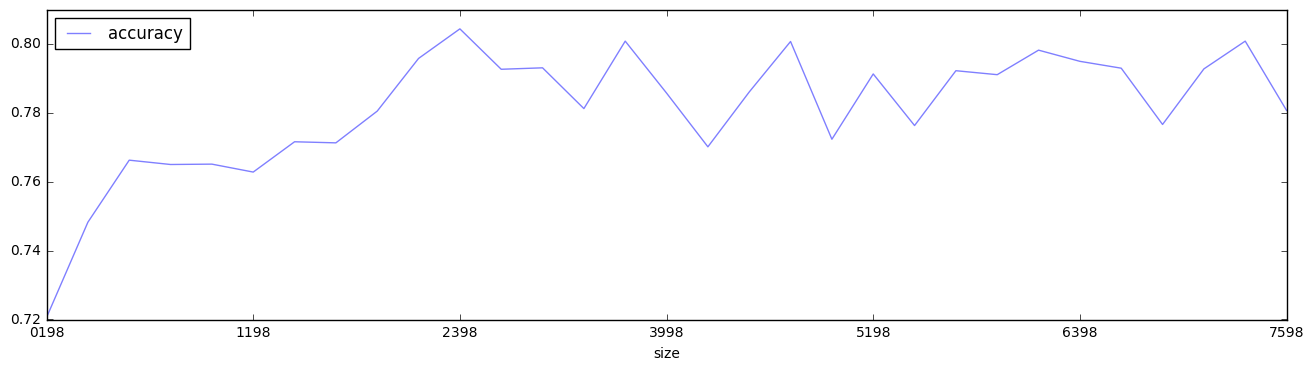

In [7]:
%matplotlib inline
test.plot( y=['accuracy'], figsize=(16,4), alpha=0.5)

In [8]:
test2 = pd.DataFrame(columns = ["size","accel","gyro","label","data_counts","loss","accuracy","macro-fmesure","NO_LABEL", "ROLL", "RUN", "DOOR"])
size2 = []
for evalfile in glob.glob("./models/20180817/eval/*/*.csv"):
    size2.append(evalfile.replace("./models/20180817/eval/","").replace("/001eval005_010_011_013.csv",""))
    df = pd.read_csv(evalfile)
    _df = df[df["accel"] == "001_20170407_000.accel.csv"]
    test2 = pd.concat([test2,_df])
test2["size"] = size2

In [9]:
test2 = test2.sort_values(by=["size"], ascending=False)

In [10]:
test2.head()

,DOOR,NO_LABEL,ROLL,RUN,accel,accuracy,data_counts,gyro,label,loss,macro-fmesure,size
0,0.662722,0.755131,0.523043,0.774048,001_20170407_000.accel.csv,0.739449,9549.0,001_20170407_000.gyro.csv,.-001001_20170407_000.csv,1.818749,0.678736,38001_20170406_000
0,0.681319,0.766095,0.553531,0.787034,001_20170407_000.accel.csv,0.753691,9549.0,001_20170407_000.gyro.csv,.-001001_20170407_000.csv,1.684721,0.696995,37001_20170406_000
0,0.691489,0.780760,0.581250,0.790781,001_20170407_000.accel.csv,0.766991,9549.0,001_20170407_000.gyro.csv,.-001001_20170407_000.csv,1.685104,0.711070,36001_20170406_000
0,0.703911,0.782382,0.585947,0.794781,001_20170407_000.accel.csv,0.770028,9549.0,001_20170407_000.gyro.csv,.-001001_20170407_000.csv,1.720193,0.716755,35001_20170406_000
0,0.700565,0.815921,0.719818,0.797416,001_20170407_000.accel.csv,0.801026,9549.0,001_20170407_000.gyro.csv,.-001001_20170407_000.csv,1.739584,0.758430,34001_20170406_000


In [11]:
test2 = test2.set_index("size")

In [ ]:
test2[:10].plot( y=['accuracy'], figsize=(16,4), alpha=0.5)

## finplot

In [1]:
import MSclass

MSclass.adddata("./cepstrums/",["013"], "./models/20180820/data/add/")

In [ ]:
from relearning import relearning

for day in ["20170406","20170407"]:
    for carid in ["011"]:
        relearning(f_cep = "./models/20180820/data/add/%s/"%day,
                            f_model = "./models/20180806/model/",
                            f_weight = "./models/20180806/weight/",
                            car_ids =  [carid],
                            eval_car_ids = [carid],
                            outeval = "./models/20180820/eval/reeval/%s/"%day,
                            outmodel = "./models/20180820/model/%s/"%day,
                            outweights = "./models/20180820/weight/%s/"%day,
                            outpredict = "./models/20180820/predict/%s"%day,
                            batch_size = 50,
                            epochs = 10,
                            units = 180,
                            timestep = 3,
                            timeshift = 1,
                        )

['./models/20180806/model/model001_005_010_013.model']
[]
['./models/20180806/model/model001_005_010_013.model']
['./models/20180820/data/add/20170407/011/0061.label.csv', './models/20180820/data/add/20170407/011/0022.label.csv', './models/20180820/data/add/20170407/011/0078.label.csv', './models/20180820/data/add/20170407/011/0011.label.csv', './models/20180820/data/add/20170407/011/0044.label.csv', './models/20180820/data/add/20170407/011/0042.label.csv', './models/20180820/data/add/20170407/011/0053.label.csv', './models/20180820/data/add/20170407/011/0058.label.csv', './models/20180820/data/add/20170407/011/0067.label.csv', './models/20180820/data/add/20170407/011/0023.label.csv', './models/20180820/data/add/20170407/011/0032.label.csv', './models/20180820/data/add/20170407/011/0033.label.csv', './models/20180820/data/add/20170407/011/0073.label.csv', './models/20180820/data/add/20170407/011/0020.label.csv', './models/20180820/data/add/20170407/011/0072.label.csv', './models/201808

/home/aj1m0n/jupyter_notebook/Datamining/20180731/create_model.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _labels["date"] = np.datetime_as_string(labels.timestamp, "D")#timeごとに整列化


./models/20180806/model/model001_005_010_013.model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 180)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 180)               259920    
_________________________________________________________________
Dense1 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense2 (Dense)               (None, 180)               32580     
_________________________________________________________________
Dense3 (Dense)               (None, 4)                 724       
_________________________________________________________________
out (Dense)                  (None, 4)                 20        
Total params: 325,824
Trainable params: 325,824
Non-trainable params: 0
___________________

/home/aj1m0n/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239936). Check your callbacks.
  % delta_t_median)


 - 60s - loss: 0.4567 - acc: 0.9226 - val_loss: 0.2217 - val_acc: 0.9541
Epoch 2/10
 - 3s - loss: 0.2069 - acc: 0.9554 - val_loss: 0.1503 - val_acc: 0.9674
Epoch 3/10
 - 3s - loss: 0.1443 - acc: 0.9665 - val_loss: 0.1108 - val_acc: 0.9692
Epoch 4/10
 - 3s - loss: 0.0973 - acc: 0.9745 - val_loss: 0.0695 - val_acc: 0.9823
Epoch 5/10
 - 3s - loss: 0.0704 - acc: 0.9805 - val_loss: 0.0520 - val_acc: 0.9864
Epoch 6/10
 - 3s - loss: 0.0524 - acc: 0.9874 - val_loss: 0.0399 - val_acc: 0.9904
Epoch 7/10
 - 3s - loss: 0.0403 - acc: 0.9904 - val_loss: 0.0299 - val_acc: 0.9936
Epoch 8/10
 - 3s - loss: 0.0308 - acc: 0.9933 - val_loss: 0.0242 - val_acc: 0.9949
Epoch 9/10
 - 3s - loss: 0.0227 - acc: 0.9956 - val_loss: 0.0177 - val_acc: 0.9963
Epoch 10/10
 - 3s - loss: 0.0177 - acc: 0.9970 - val_loss: 0.0126 - val_acc: 0.9979
./models/20180820/eval/reeval/20170407/0060/011eval001_005_010_013.csv
16354/16354 [==============================] - 4s 225us/step
./cepstrums/011/011_20170407_000.label.csv
1809

/home/aj1m0n/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195317). Check your callbacks.
  % delta_t_median)


 - 67s - loss: 0.7751 - acc: 0.7799 - val_loss: 0.4417 - val_acc: 0.8132
Epoch 2/10
 - 6s - loss: 0.4099 - acc: 0.8299 - val_loss: 0.3461 - val_acc: 0.8553
Epoch 3/10
 - 6s - loss: 0.3314 - acc: 0.8625 - val_loss: 0.2790 - val_acc: 0.8900
Epoch 4/10
 - 5s - loss: 0.2726 - acc: 0.8911 - val_loss: 0.2216 - val_acc: 0.9155
Epoch 5/10
 - 5s - loss: 0.2193 - acc: 0.9145 - val_loss: 0.1691 - val_acc: 0.9358
Epoch 6/10
 - 6s - loss: 0.1757 - acc: 0.9321 - val_loss: 0.1525 - val_acc: 0.9424
Epoch 7/10
 - 6s - loss: 0.1288 - acc: 0.9525 - val_loss: 0.0947 - val_acc: 0.9700
Epoch 8/10
 - 6s - loss: 0.0946 - acc: 0.9673 - val_loss: 0.0695 - val_acc: 0.9783
Epoch 9/10
 - 6s - loss: 0.0654 - acc: 0.9788 - val_loss: 0.0402 - val_acc: 0.9887
Epoch 10/10
 - 5s - loss: 0.0441 - acc: 0.9870 - val_loss: 0.0262 - val_acc: 0.9943
./models/20180820/eval/reeval/20170407/0037/011eval001_005_010_013.csv
16354/16354 [==============================] - 4s 246us/step
./cepstrums/011/011_20170407_000.label.csv
1809

/home/aj1m0n/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106286). Check your callbacks.
  % delta_t_median)


 - 9s - loss: 0.0568 - acc: 0.9835 - val_loss: 0.0512 - val_acc: 0.9840
./models/20180820/eval/reeval/20170407/0015/011eval001_005_010_013.csv
18099/18099 [==============================] - 10s 547us/step
./cepstrums/011/011_20170511_000.label.csv
17009/17009 [==============================] - 12s 687us/step
./cepstrums/011/011_20170512_000.label.csv
Goodbye, world!
./models/20180820/data/add/20170407/011/0068.label.csv
0068
['./models/20180820/data/add/20170407/011/0068.label.csv']
./models/20180806/model/model001_005_010_013.model


### margin sampling

In [3]:
import MSclass

In [ ]:
MSclass.marginsampling_for_LSTM("./models/20170809/predict/",["001","010","011","013"],"./models/20170820/")